# Importing Necessery Libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data Loading and Preprocessing:

In [2]:
img_size= (128, 128)
batch_size= 32

In [6]:
train_dir =r"C:\Users\LENOVO\covid\data\test"
test_dir = r"C:\Users\LENOVO\covid/data/test"

In [7]:
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
)

Found 1288 files belonging to 3 classes.
Using 1031 files for training.


In [8]:
val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
)

Found 1288 files belonging to 3 classes.
Using 257 files for validation.


In [9]:
class_names = train_ds.class_names
print("Original Classes:", class_names)

Original Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']


In [10]:
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 1288 files belonging to 3 classes.


In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# Data Modeling:

In [13]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [14]:
base_model.trainable = False

In [15]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,173,699 (27.37 MB)

 Trainable params: 133,891 (523.01 KB)

 Non-trainable params: 7,039,808 (26.85 MB)

In [17]:
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.7265 - loss: 0.8068 - val_accuracy: 0.8677 - val_loss: 0.3441
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.8972 - loss: 0.3045 - val_accuracy: 0.8716 - val_loss: 0.3539
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.9428 - loss: 0.2128 - val_accuracy: 0.8872 - val_loss: 0.2979
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.9602 - loss: 0.1548 - val_accuracy: 0.9300 - val_loss: 0.2172
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.9719 - loss: 0.1007 - val_accuracy: 0.9494 - val_loss: 0.1706
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.9680 - loss: 0.1043 - val_accuracy: 0.9572 - val_loss: 0.1387
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9777 - loss: 0.0751 - val_accuracy: 0.9689 - val_loss: 0.1239
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.9835 - loss: 0.0629 - val_accuracy: 0.9689 - v

In [19]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9899 - loss: 0.0407
Test accuracy: 98.99%


# Model Evaluation:

In [20]:
y_true = []
y_predicted = []

In [21]:
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images)
    y_predicted.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3

In [22]:
y_true = np.array(y_true)
y_pred = np.array(y_predicted)

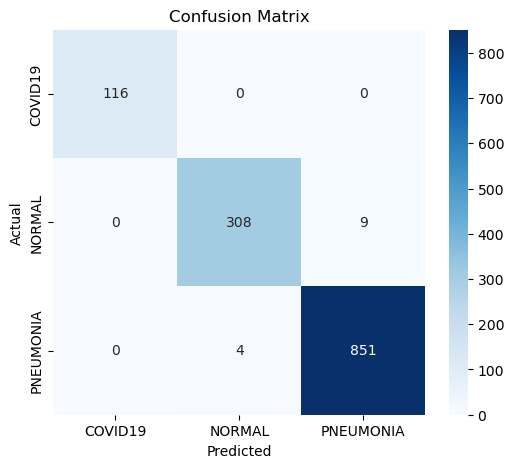

In [23]:
cm = confusion_matrix(y_true, y_predicted)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [24]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

     COVID19       1.00      1.00      1.00       116
      NORMAL       0.99      0.97      0.98       317
   PNEUMONIA       0.99      1.00      0.99       855

    accuracy                           0.99      1288
   macro avg       0.99      0.99      0.99      1288
weighted avg       0.99      0.99      0.99      1288



# Saving Model:

In [25]:
model.save("covid_model1.keras")

In [ ]:
model = tf.keras.models.load_model("covid_model1.keras")